In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,GRU, Dense, Bidirectional
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.layers import TimeDistributed, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [3]:
df = pd.read_csv(r'C:\Users\omgit\Desktop\My Projects for Resume\Projects\Deep Learning\electricityConsumptionAndProductioction.csv')

In [4]:
df.head()

,DateTime,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
0,2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
1,2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2,2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
3,2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
4,2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30


## Data Preparation

In [5]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df[['Consumption', 'Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass']])

In [6]:
scaled_df = pd.DataFrame(scaled_df, columns=['Consumption', 'Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass'])

In [7]:
len(df)

46011

In [8]:
def create_sequences(df, seq_length):
    sequences = []
    labels = []
    for i in range(len(df) - seq_length):
        seq = df.iloc[i:i+seq_length].values
        label = df['Consumption'].iloc[i+seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

SEQ_LENGTH = 24  # for 24 hours sequence
sequences, labels = create_sequences(scaled_df, SEQ_LENGTH)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, shuffle=False)

## Simple RNN

In [10]:
rnn_model = Sequential([
    SimpleRNN(50, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])),
    SimpleRNN(50),
    Dense(1)
])

rnn_model.compile(optimizer='adam', loss='mean_squared_error')

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 24, 50)            3000      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 8,101
Trainable params: 8,101
Non-trainable params: 0
_________________________________________________________________


In [11]:
rnn_history = rnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
920/920 [==============================] - 63s 67ms/step - loss: 0.0027 - val_loss: 7.6225e-04
Epoch 2/20
920/920 [==============================] - 63s 69ms/step - loss: 8.9930e-04 - val_loss: 6.6878e-04
Epoch 3/20
920/920 [==============================] - 62s 67ms/step - loss: 8.0060e-04 - val_loss: 7.8183e-04
Epoch 4/20
920/920 [==============================] - 52s 57ms/step - loss: 7.8013e-04 - val_loss: 6.5134e-04
Epoch 5/20
920/920 [==============================] - 52s 57ms/step - loss: 6.7905e-04 - val_loss: 6.3861e-04
Epoch 6/20
920/920 [==============================] - 55s 60ms/step - loss: 6.4987e-04 - val_loss: 6.6111e-04
Epoch 7/20
920/920 [==============================] - 65s 70ms/step - loss: 6.5526e-04 - val_loss: 5.0684e-04
Epoch 8/20
920/920 [==============================] - 67s 73ms/step - loss: 6.4365e-04 - val_loss: 5.1050e-04
Epoch 9/20
920/920 [==============================] - 67s 73ms/step - loss: 5.7226e-04 - val_loss: 4.9782e-04
Epoch 10/20
92

In [12]:
# Simple RNN Model Evaluation
rnn_predictions = rnn_model.predict(X_test)

# Calculate evaluation metrics for Simple RNN
rnn_r2 = r2_score(y_test, rnn_predictions)
rnn_mae = mean_absolute_error(y_test, rnn_predictions)
rnn_mse = mean_squared_error(y_test, rnn_predictions)
rnn_rmse = np.sqrt(rnn_mse)

print(f'Simple RNN - R² Score: {rnn_r2}')
print(f'Simple RNN - Mean Absolute Error (MAE): {rnn_mae}')
print(f'Simple RNN - Mean Squared Error (MSE): {rnn_mse}')
print(f'Simple RNN - Root Mean Squared Error (RMSE): {rnn_rmse}')

288/288 [==============================] - 3s 10ms/step
Simple RNN - R² Score: 0.9850454889423216
Simple RNN - Mean Absolute Error (MAE): 0.015418622562873012
Simple RNN - Mean Squared Error (MSE): 0.0003994841600434102
Simple RNN - Root Mean Squared Error (RMSE): 0.019987099840732526


In [13]:
# Normalize the data
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df[['Consumption', 'Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass']])

# Convert to a DataFrame
scaled_df = pd.DataFrame(scaled_df, columns=['Consumption', 'Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass'])

# Create sequences
def create_sequences(df, seq_length):
    sequences = []
    labels = []
    for i in range(len(df) - seq_length):
        seq = df.iloc[i:i+seq_length].values
        label = df['Consumption'].iloc[i+seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

SEQ_LENGTH = 24  # for 24 hours sequence
sequences, labels = create_sequences(scaled_df, SEQ_LENGTH)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, shuffle=False)

# Simple RNN Model Definition
rnn_model = Sequential([
    SimpleRNN(50, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])),
    SimpleRNN(50),
    Dense(1)
])

rnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Simple RNN Model Training
rnn_history = rnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Simple RNN Model Evaluation
rnn_predictions = rnn_model.predict(X_test)

# Calculate evaluation metrics for Simple RNN
rnn_r2 = r2_score(y_test, rnn_predictions)
rnn_mae = mean_absolute_error(y_test, rnn_predictions)
rnn_mse = mean_squared_error(y_test, rnn_predictions)
rnn_rmse = np.sqrt(rnn_mse)

print(f'Simple RNN - R² Score: {rnn_r2}')
print(f'Simple RNN - Mean Absolute Error (MAE): {rnn_mae}')
print(f'Simple RNN - Mean Squared Error (MSE): {rnn_mse}')
print(f'Simple RNN - Root Mean Squared Error (RMSE): {rnn_rmse}')

Epoch 1/20
920/920 [==============================] - 64s 68ms/step - loss: 0.0088 - val_loss: 0.0028
Epoch 2/20
920/920 [==============================] - 63s 69ms/step - loss: 0.0013 - val_loss: 9.0303e-04
Epoch 3/20
920/920 [==============================] - 62s 67ms/step - loss: 0.0011 - val_loss: 7.1222e-04
Epoch 4/20
920/920 [==============================] - 62s 67ms/step - loss: 0.0010 - val_loss: 6.9468e-04
Epoch 5/20
920/920 [==============================] - 63s 69ms/step - loss: 8.5783e-04 - val_loss: 0.0028
Epoch 6/20
920/920 [==============================] - 61s 67ms/step - loss: 8.6487e-04 - val_loss: 0.0010
Epoch 7/20
920/920 [==============================] - 62s 67ms/step - loss: 7.5979e-04 - val_loss: 7.6940e-04
Epoch 8/20
920/920 [==============================] - 62s 67ms/step - loss: 7.1191e-04 - val_loss: 8.5768e-04
Epoch 9/20
920/920 [==============================] - 61s 67ms/step - loss: 6.6659e-04 - val_loss: 5.1360e-04
Epoch 10/20
920/920 [=================

## LSTM

In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], scaled_df.shape[1]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], scaled_df.shape[1]))

In [ ]:
model = Sequential([
    LSTM(64, input_shape=(SEQ_LENGTH, scaled_df.shape[1]), return_sequences=False),
    Dense(1)  # Predicting next consumption value
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [16]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae:.4f}")

Epoch 1/20
1035/1035 [==============================] - 14s 9ms/step - loss: 0.0049 - mae: 0.0490 - val_loss: 0.0020 - val_mae: 0.0370
Epoch 2/20
1035/1035 [==============================] - 9s 8ms/step - loss: 0.0012 - mae: 0.0266 - val_loss: 8.6659e-04 - val_mae: 0.0220
Epoch 3/20
1035/1035 [==============================] - 9s 8ms/step - loss: 8.7554e-04 - mae: 0.0225 - val_loss: 6.5929e-04 - val_mae: 0.0190
Epoch 4/20
1035/1035 [==============================] - 9s 8ms/step - loss: 7.2813e-04 - mae: 0.0205 - val_loss: 5.5917e-04 - val_mae: 0.0174
Epoch 5/20
1035/1035 [==============================] - 9s 8ms/step - loss: 6.1818e-04 - mae: 0.0188 - val_loss: 5.3848e-04 - val_mae: 0.0170
Epoch 6/20
1035/1035 [==============================] - 9s 8ms/step - loss: 5.7587e-04 - mae: 0.0180 - val_loss: 7.1976e-04 - val_mae: 0.0210
Epoch 7/20
1035/1035 [==============================] - 9s 8ms/step - loss: 5.3597e-04 - mae: 0.0175 - val_loss: 8.1666e-04 - val_mae: 0.0219
Epoch 8/20
1035/1

288/288 [==============================] - 2s 4ms/step


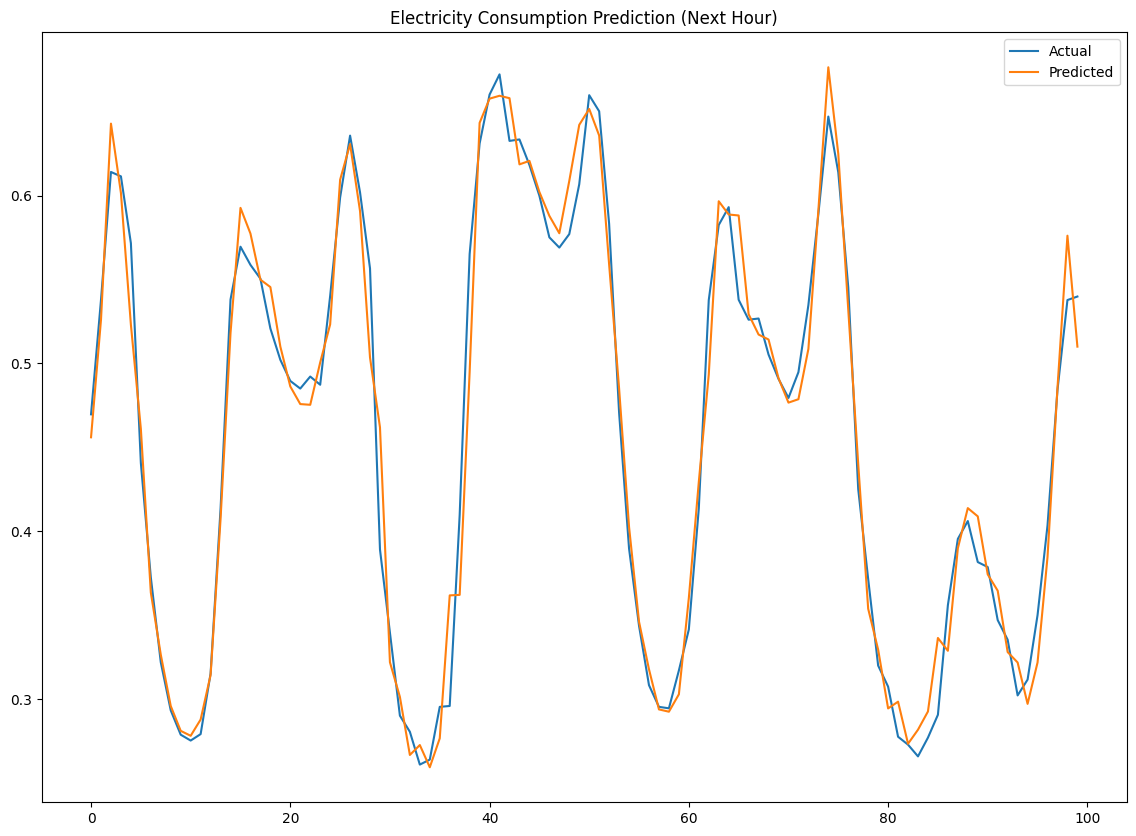

In [ ]:
predicted = model.predict(X_test)

plt.figure(figsize=(14, 10))
plt.plot(y_test[:100], label="Actual")
plt.plot(predicted[:100], label="Predicted")
plt.legend()
plt.title("Electricity Consumption Prediction (Next Hour)")
plt.show()

In [ ]:
def clear_model():
    import tensorflow.keras.backend as K
    import gc
    K.clear_session()
    gc.collect()

In [19]:
clear_model()

## GRU

In [20]:
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam

In [21]:
model = Sequential([
    GRU(64, input_shape=(SEQ_LENGTH, scaled_df.shape[1]), return_sequences=False),
    Dense(1)  
])

In [22]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

Epoch 1/20
1035/1035 [==============================] - 10s 8ms/step - loss: 0.0041 - mae: 0.0422 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 2/20
1035/1035 [==============================] - 9s 8ms/step - loss: 9.3671e-04 - mae: 0.0234 - val_loss: 6.7112e-04 - val_mae: 0.0202
Epoch 3/20
1035/1035 [==============================] - 7s 7ms/step - loss: 7.4981e-04 - mae: 0.0208 - val_loss: 6.5166e-04 - val_mae: 0.0193
Epoch 4/20
1035/1035 [==============================] - 7s 7ms/step - loss: 6.5462e-04 - mae: 0.0193 - val_loss: 5.7315e-04 - val_mae: 0.0180
Epoch 5/20
1035/1035 [==============================] - 7s 7ms/step - loss: 5.7172e-04 - mae: 0.0181 - val_loss: 0.0011 - val_mae: 0.0284
Epoch 6/20
1035/1035 [==============================] - 7s 7ms/step - loss: 5.3357e-04 - mae: 0.0175 - val_loss: 4.6777e-04 - val_mae: 0.0162
Epoch 7/20
1035/1035 [==============================] - 7s 7ms/step - loss: 4.9487e-04 - mae: 0.0167 - val_loss: 4.4906e-04 - val_mae: 0.0159
Epoch 8/20
1035/1

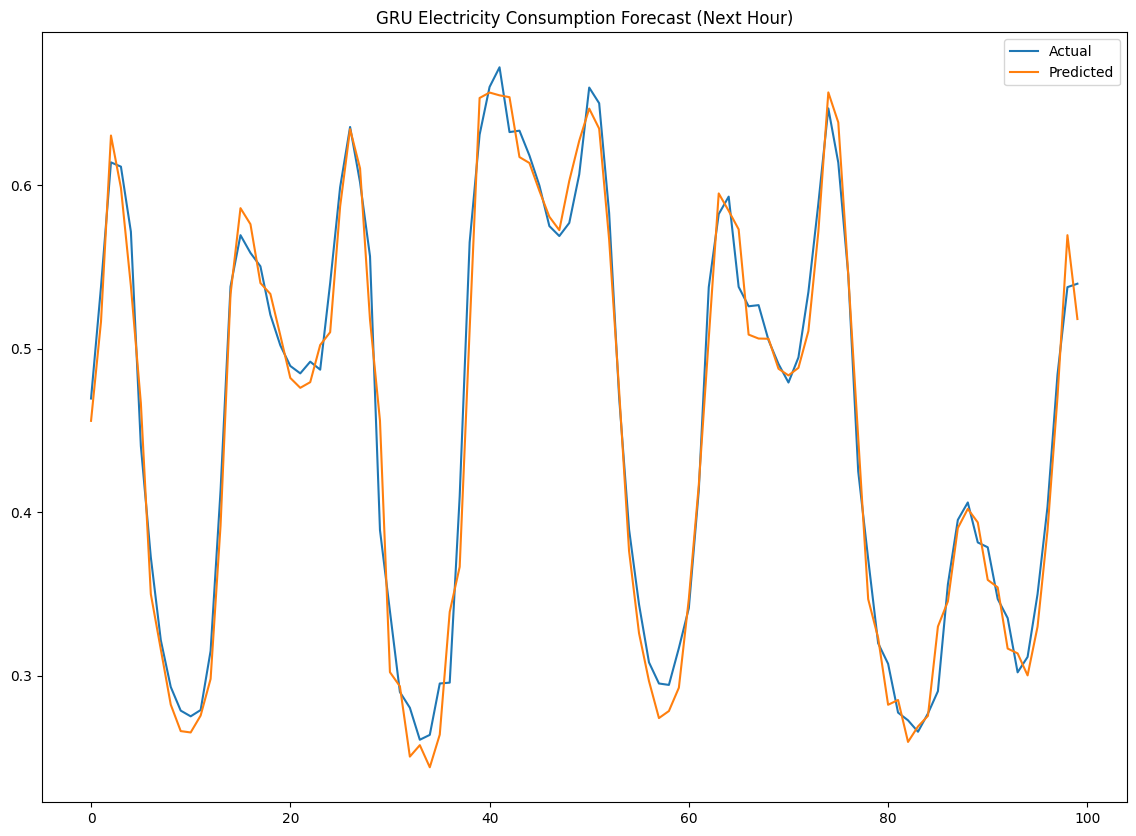

In [23]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

# Evaluate
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae:.4f}")

# Predict and plot
predicted = model.predict(X_test)

import matplotlib.pyplot as plt
plt.figure(figsize=(14, 10))
plt.plot(y_test[:100], label="Actual")
plt.plot(predicted[:100], label="Predicted")
plt.legend()
plt.title("GRU Electricity Consumption Forecast (Next Hour)")
plt.show()

## LSTM with Attention Mechanism Built in

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Concatenate
from tensorflow.keras.models import Model

# Define input shape
SEQ_LENGTH = 24  
NUM_FEATURES = scaled_df.shape[1]  
OUTPUT_DIM = 1  

inputs = Input(shape=(SEQ_LENGTH, NUM_FEATURES)) 
lstm_out = LSTM(64, return_sequences=True)(inputs) 
attention_out = Attention()([lstm_out, lstm_out])  
combined = Concatenate()([lstm_out, attention_out])  
context_vector = tf.reduce_mean(combined, axis=1)  

output = Dense(OUTPUT_DIM)(context_vector)  

model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 24, 9)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 24, 64)       18944       ['input_1[0][0]']                
                                                                                                  
 attention (Attention)          (None, 24, 64)       0           ['lstm[0][0]',                   
                                                                  'lstm[0][0]']                   
                                                                                                  
 concatenate (Concatenate)      (None, 24, 128)      0           ['lstm[0][0]',               

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae:.4f}")

Epoch 1/20
1035/1035 [==============================] - 10s 8ms/step - loss: 0.0102 - mae: 0.0765 - val_loss: 0.0068 - val_mae: 0.0621
Epoch 2/20
1035/1035 [==============================] - 8s 8ms/step - loss: 0.0038 - mae: 0.0458 - val_loss: 0.0039 - val_mae: 0.0474
Epoch 3/20
1035/1035 [==============================] - 8s 8ms/step - loss: 0.0026 - mae: 0.0382 - val_loss: 0.0029 - val_mae: 0.0416
Epoch 4/20
1035/1035 [==============================] - 8s 8ms/step - loss: 0.0019 - mae: 0.0323 - val_loss: 0.0020 - val_mae: 0.0330
Epoch 5/20
1035/1035 [==============================] - 8s 8ms/step - loss: 0.0014 - mae: 0.0286 - val_loss: 0.0013 - val_mae: 0.0267
Epoch 6/20
1035/1035 [==============================] - 8s 8ms/step - loss: 0.0012 - mae: 0.0256 - val_loss: 9.8018e-04 - val_mae: 0.0230
Epoch 7/20
1035/1035 [==============================] - 8s 8ms/step - loss: 9.5465e-04 - mae: 0.0233 - val_loss: 0.0012 - val_mae: 0.0276
Epoch 8/20
1035/1035 [==============================]

288/288 [==============================] - 1s 3ms/step


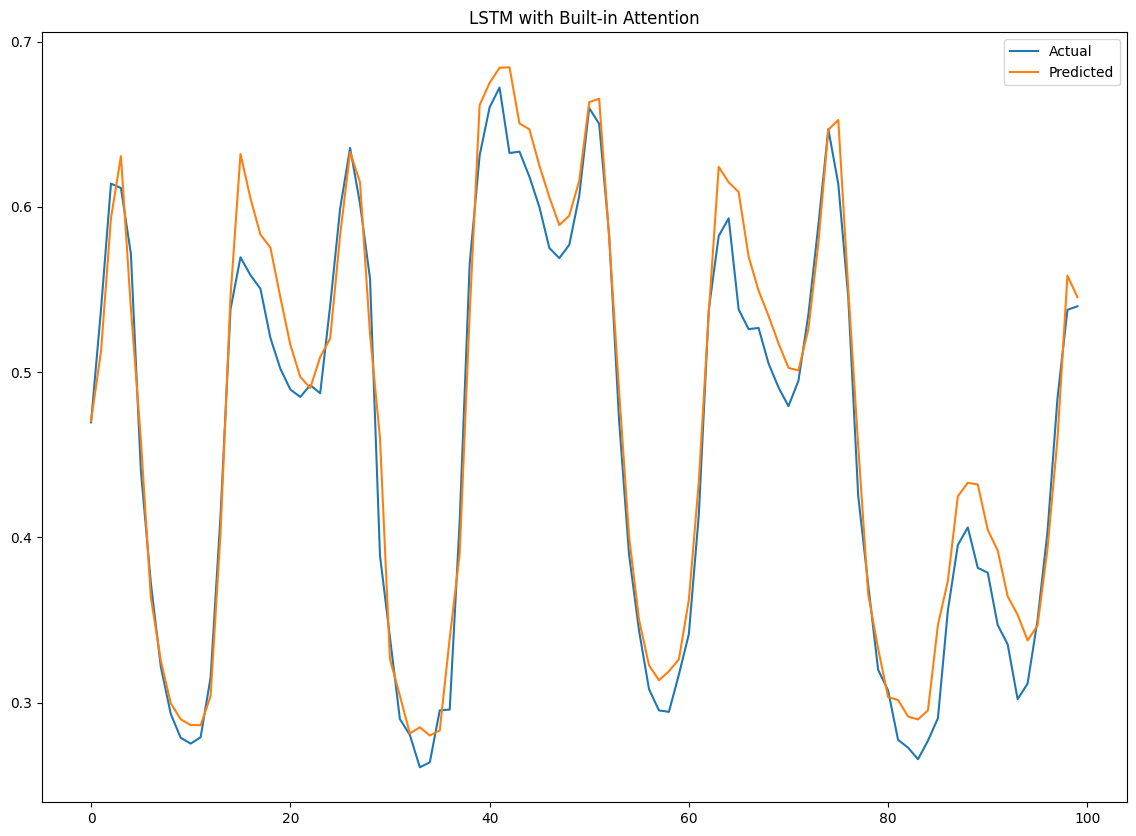

In [ ]:
predicted = model.predict(X_test)

import matplotlib.pyplot as plt
plt.figure(figsize=(14, 10))
plt.plot(y_test[:100], label='Actual')
plt.plot(predicted[:100], label='Predicted')
plt.legend()
plt.title("LSTM with Built-in Attention")
plt.show()

## CNN

In [27]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

In [ ]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(SEQ_LENGTH, scaled_df.shape[1])))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 22, 64)            1792      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 11, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 704)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                45120     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                      

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
1035/1035 [==============================] - 8s 5ms/step - loss: 0.0087 - mae: 0.0698 - val_loss: 0.0023 - val_mae: 0.0348
Epoch 2/20
1035/1035 [==============================] - 4s 4ms/step - loss: 0.0037 - mae: 0.0462 - val_loss: 0.0018 - val_mae: 0.0316
Epoch 3/20
1035/1035 [==============================] - 4s 4ms/step - loss: 0.0025 - mae: 0.0384 - val_loss: 0.0013 - val_mae: 0.0276
Epoch 4/20
1035/1035 [==============================] - 4s 4ms/step - loss: 0.0021 - mae: 0.0352 - val_loss: 0.0011 - val_mae: 0.0255
Epoch 5/20
1035/1035 [==============================] - 4s 4ms/step - loss: 0.0019 - mae: 0.0333 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 6/20
1035/1035 [==============================] - 4s 4ms/step - loss: 0.0018 - mae: 0.0321 - val_loss: 7.5630e-04 - val_mae: 0.0202
Epoch 7/20
1035/1035 [==============================] - 5s 4ms/step - loss: 0.0017 - mae: 0.0316 - val_loss: 6.6750e-04 - val_mae: 0.0193
Epoch 8/20
1035/1035 [==============================] 

288/288 [==============================] - 1s 3ms/step - loss: 7.9879e-04 - mae: 0.0217
Test MAE: 0.0217
288/288 [==============================] - 0s 1ms/step


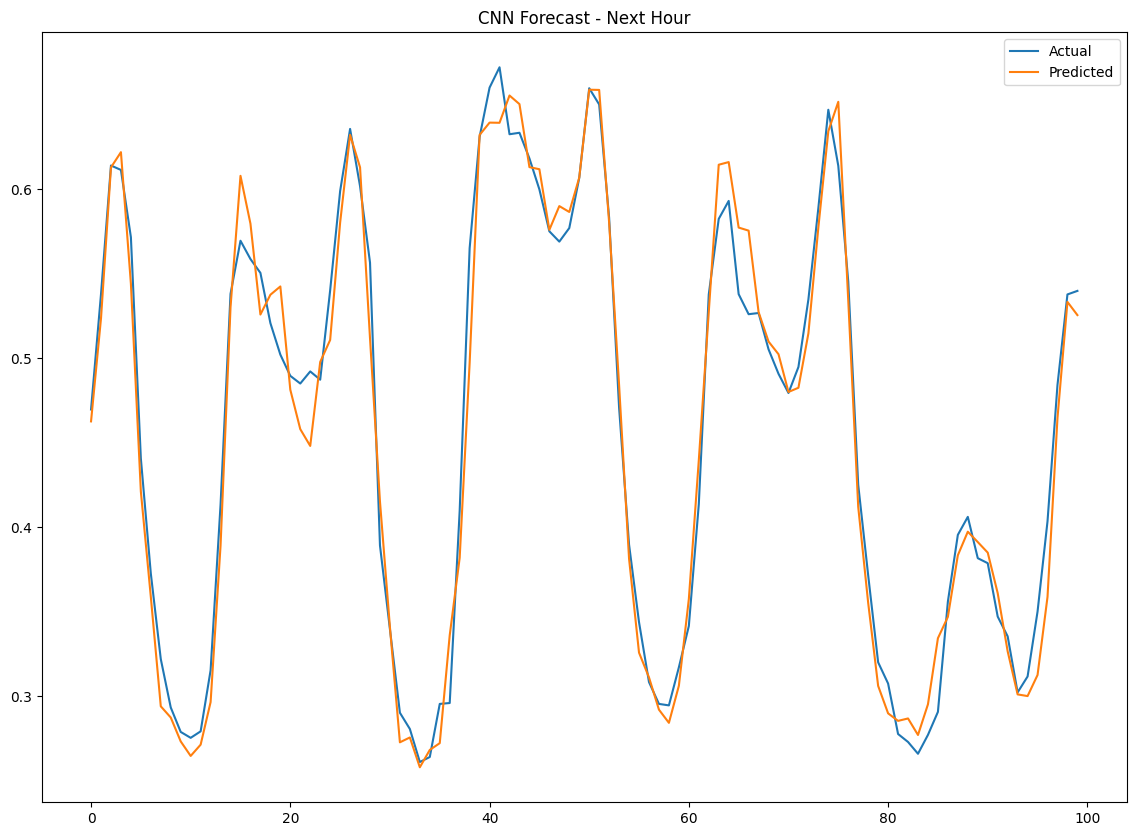

In [ ]:
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae:.4f}")

predicted = model.predict(X_test)

import matplotlib.pyplot as plt
plt.figure(figsize=(14, 10))
plt.plot(y_test[:100], label='Actual')
plt.plot(predicted[:100], label='Predicted')
plt.legend()
plt.title("CNN Forecast - Next Hour")
plt.show()